# DSCI 100: Group Project

## Classification of Facebook Post Type Using Social Media Performance Metrics

#### Introduction:

The rapid advancement of technology has transformed the business world. Social media platforms have become the best place for businesses to advertise their brands by increasing customer engagement. 
Our report focuses on the most popular social network worldwide, Facebook, with over 2.7 billion monthly active users (Statista, 2021). 

The dataset *Facebook performance metrics* (Moro et al., 2016) contains data related to posts published throughout the year 2014 on a renowned cosmetics brand's Facebook page. Post information such as type (photo, status, link, or video), time posted (month, day of week, and hour), user engagement (comments, likes, and shares), impressions on each post (too many columns to list here), and whether the post was paid or unpaid is included in the dataset. 

This project uses all relevant columns from this dataset to determine the type of a brand's Facebook post. We determine which of these metrics are relevant in our cleaning and exploration of the data. We use our chosen predictors to build a prediction model using the K-nearest neighbour classification algorithm, implemented in the `tidymodels` framework, to predict the type of a post (photo, status, link, or video). 


#### Preliminary exploratory data analysis:

We begin by loading the relevant libraries. We include `tidymodels` for the KNN classification algorithm, and `GGally` for the ggpairs plotting function. 

In [226]:
# Load libraries for preliminary data analysis:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

The following cell loads the dataset into R; as the dataset on the web is contained in a zip folder, the .csv file was manually extracted and pushed to the working Github repository.

The dataset is already in tidy format. The column headings were made more usable by removing spaces and shortening longer headings. We find that we have 6 NAs in our data set, so we use `na.omit` function to remove them. In addition, since we are working with `type`, `category`, `post month`, `post weekday`, `post hour`, and `paid` as categorical statistical variables, we convert them to factors using the function `as_factor`. 

In [227]:
# displays first and last 8 rows of the dataset
options(repr.matrix.max.rows = 16)
# Set the seed
set.seed(123)

# Load the data in
fb_data_raw <- read_csv2("https://gist.githubusercontent.com/KolCrooks/691e5890b6747b4777d6032f019b2c0f/raw/20629a5da3d5a7683e3071798876f3e4b204fbbb/fb_data.csv",  col_types = cols())

# NA Rows:
sum(is.na(fb_data_raw))

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.



[1] 6

In [234]:
# Clean the data, change column names, and convert some columns to factors:
fb_data_clean_cols <- fb_data_raw
colnames(fb_data_clean_cols) <- c("page_likes", "type", "category", "post_month", "post_weekday", "post_hour", "paid", "reach", 
      "impressions", "engaged_users", "post_consumers", "post_consumptions", "impressions_by_people_that_liked_page", 
      "reach_by_people_that_like_page", "people_liked_and_engaged", "comments", "likes", "shares", "interactions")
fb_data_clean <- fb_data_clean_cols %>% 
        mutate(type = as_factor(type)) %>% 
        mutate(category = as_factor(category)) %>% 
        mutate(post_month = as_factor(post_month)) %>% 
        mutate(post_weekday = as_factor(post_weekday)) %>% 
        mutate(post_hour = as_factor(post_hour)) %>% 
        mutate(paid = as_factor(paid)) %>% 
        na.omit()

fb_data_clean

page_likes,type,category,post_month,post_weekday,post_hour,paid,reach,impressions,engaged_users,post_consumers,post_consumptions,impressions_by_people_that_liked_page,reach_by_people_that_like_page,people_liked_and_engaged,comments,likes,shares,interactions
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186
139441,Photo,3,12,1,3,1,11692,19479,481,265,364,15432,9328,379,3,249,27,279
139441,Photo,3,12,7,9,1,13720,24137,537,232,305,19728,11056,422,0,325,14,339
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [235]:
# check that all NAs are removed
# NA Rows:
sum(is.na(fb_data_clean))

[1] 0

Here, we split our data set into a training set, `fb_train`, and a testing set, `fb_test`, using the `initial_split` function. We do this so that we can train our KNN classifier using only the training set; then, to evaluate the accuracy of the classifier, we can use it to predict the posts' types (which we know) in the test set. In order to train a more accurate model while still having an accurate evaluation of its performance, we allocate 75% of our data for training and reserve 25% for testing. As we want to classify post type as our target variable, we pass `type` as the `strata` argument in `initial_split`. 

In [236]:
# Split the data:
fb_split <- initial_split(fb_data_clean, prop = 0.75, strata = type)
fb_train <- training(fb_split)
fb_test <- testing(fb_split)

# ensure fb_train and fb_test contain 75% and 25% of data, respectively
nrow(fb_train)
nrow(fb_test)

[1] 372

[1] 123

## Selecting our predictors

To figure out which predictors to use, we use `ggpairs` to determine how well each column can predict post type. To do this we will compare each post type's box plot with that of the potential predictor.  Before using ggpairs, we want to take out the columns that we already know will not work; this will reduce clutter in the plot while allowing us to more accurately compare the remaing predictors.

The columns we know we cannot use as predictors are those that are factors; these are the time-based columns `post_month`, `post_weekday`, and `post_hour`, and the columns `category` and `paid`. We perform these adjustments to both the training set and the testing set, to ensure that we do not end up with differing columns that will affect the results or interpretation of our model.

In [240]:
# Columns before selection
colnames(fb_train)

colnames(fb_test)

[1] "page_likes"                           
 [2] "type"                                 
 [3] "category"                             
 [4] "post_month"                           
 [5] "post_weekday"                         
 [6] "post_hour"                            
 [7] "paid"                                 
 [8] "reach"                                
 [9] "impressions"                          
[10] "engaged_users"                        
[11] "post_consumers"                       
[12] "post_consumptions"                    
[13] "impressions_by_people_that_liked_page"
[14] "reach_by_people_that_like_page"       
[15] "people_liked_and_engaged"             
[16] "comments"                             
[17] "likes"                                
[18] "shares"                               
[19] "interactions"

[1] "page_likes"                           
 [2] "type"                                 
 [3] "category"                             
 [4] "post_month"                           
 [5] "post_weekday"                         
 [6] "post_hour"                            
 [7] "paid"                                 
 [8] "reach"                                
 [9] "impressions"                          
[10] "engaged_users"                        
[11] "post_consumers"                       
[12] "post_consumptions"                    
[13] "impressions_by_people_that_liked_page"
[14] "reach_by_people_that_like_page"       
[15] "people_liked_and_engaged"             
[16] "comments"                             
[17] "likes"                                
[18] "shares"                               
[19] "interactions"

In [241]:
fb_train_selected1 <- fb_train %>% 
            select(-post_month, -post_weekday, -post_hour, -category, -paid) %>%
            select(type, page_likes, reach:interactions) # reorder the df so that type is first, so that we can display only that row

fb_test_selected1 <- fb_test %>% 
            select(-post_month, -post_weekday, -post_hour, -category, -paid) %>%
            select(type, page_likes, reach:interactions) # reorder the df so that type is first, so that we can display only that row

# Columns after selection
colnames(fb_train_selected1)
colnames(fb_test_selected1)

[1] "type"                                 
 [2] "page_likes"                           
 [3] "reach"                                
 [4] "impressions"                          
 [5] "engaged_users"                        
 [6] "post_consumers"                       
 [7] "post_consumptions"                    
 [8] "impressions_by_people_that_liked_page"
 [9] "reach_by_people_that_like_page"       
[10] "people_liked_and_engaged"             
[11] "comments"                             
[12] "likes"                                
[13] "shares"                               
[14] "interactions"

[1] "type"                                 
 [2] "page_likes"                           
 [3] "reach"                                
 [4] "impressions"                          
 [5] "engaged_users"                        
 [6] "post_consumers"                       
 [7] "post_consumptions"                    
 [8] "impressions_by_people_that_liked_page"
 [9] "reach_by_people_that_like_page"       
[10] "people_liked_and_engaged"             
[11] "comments"                             
[12] "likes"                                
[13] "shares"                               
[14] "interactions"

Here, we use the `ggpairs` function to generate box plots of each column variable, for each post type. To make the plots more readable, we do this in two separate plots (each with approximately half the columns in the training data set).

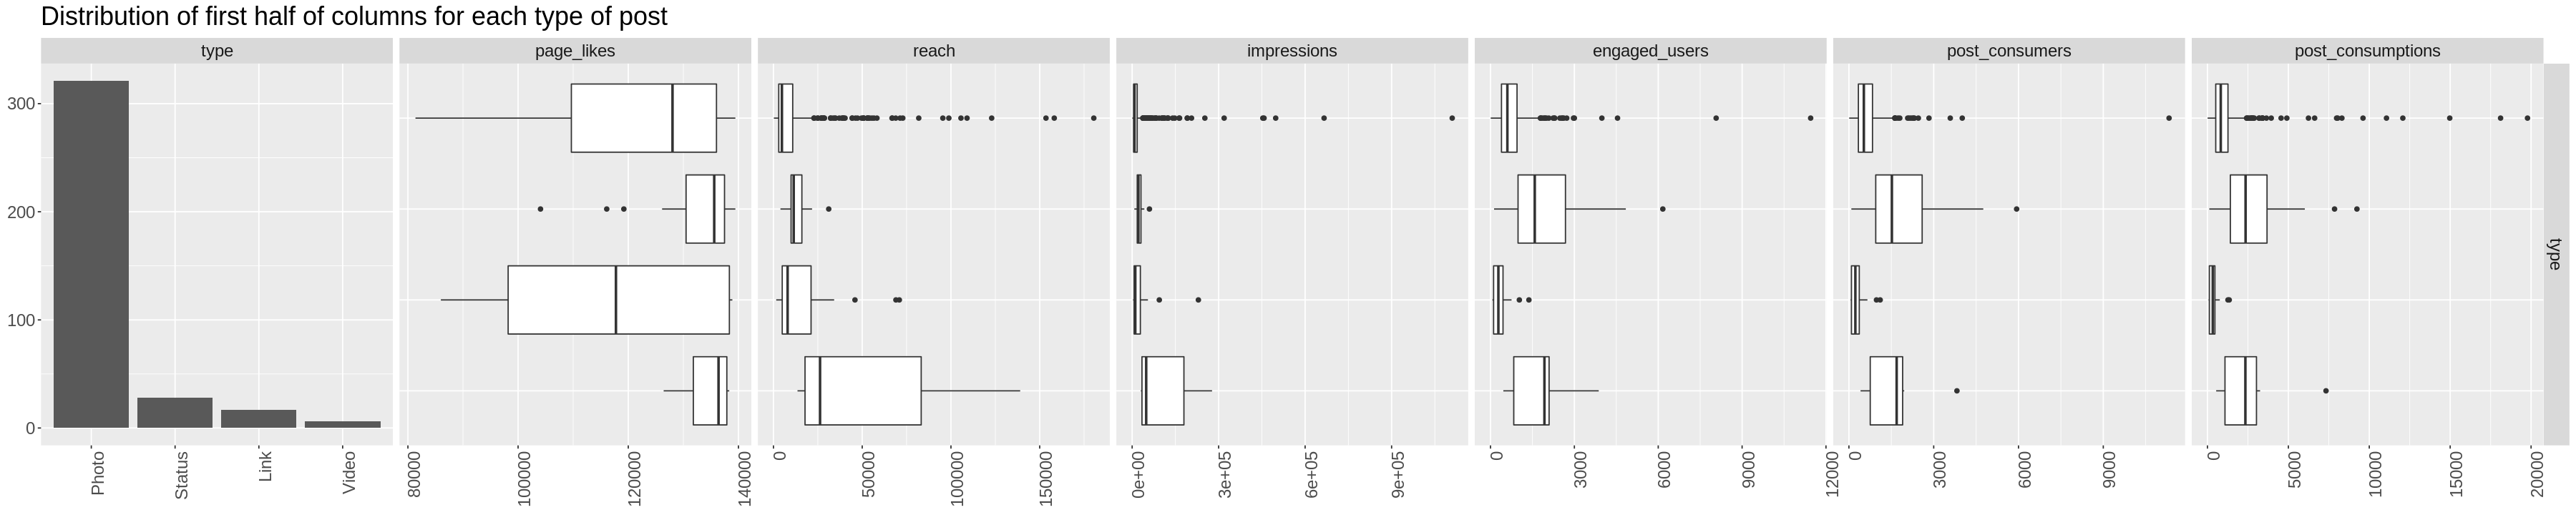

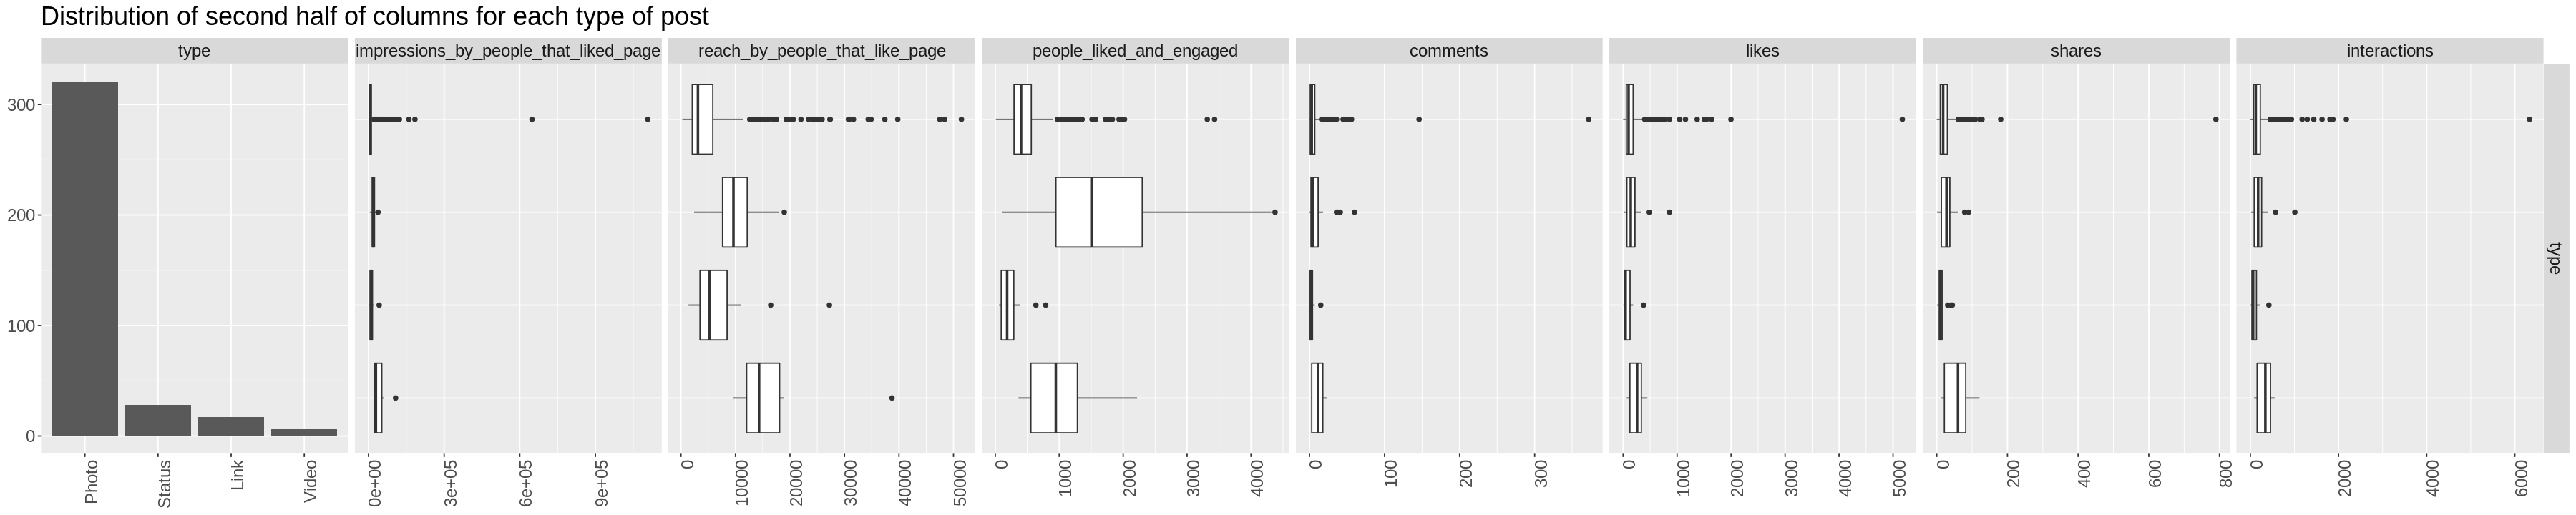

In [247]:
options(repr.plot.height = 6, repr.plot.width = 30)
fb_select_plot1_first <- fb_train_selected1 %>%
    select(type:post_consumptions) %>% 
    ggpairs() +
    ggtitle("Distribution of first half of columns for each type of post") +
    theme(text = element_text(size=18),
            axis.text.x = element_text(angle = 90, hjust = 1))

fb_select_plot1_second <- fb_train_selected1 %>%
    select(type, impressions_by_people_that_liked_page:interactions) %>% 
    ggpairs() +
    ggtitle("Distribution of second half of columns for each type of post") +
    theme(text = element_text(size=18),
            axis.text.x = element_text(angle = 90, hjust = 1))

# Select just the top row of each plot because it is the only thing that we are trying to compare
fb_select_plot1_first$nrow <- 1
fb_select_plot1_first$yAxisLabels <- fb_select_plot1_first$yAxisLabels[1]
fb_select_plot1_first

fb_select_plot1_second$nrow <- 1
fb_select_plot1_second$yAxisLabels <- fb_select_plot1_second$yAxisLabels[1]
fb_select_plot1_second

Looking at this plot, we can begin to analyze which predictors may or may not be good classifiers for our target variable. We want to avoid using predictors that have minimal variability within each type, and those which have a high level of overlap between all types.
- we eliminate `page_likes` because this column measures the total likes of the facebook page at the time a post was published, and is not necessarily related to any specific post.
- similarly, we eliminate `reach` as this column is simply the number of users for whom the post showed up on their facebook feed, and sheds no light on how the user may have interacted with the post. 
- we eliminate `impressions` because the difference of the boxes in the first three types look the same, meaning there is less variation in the data. While the boxplot for videos does look different from the rest, the many outliers of the boxplot of photos occupy similar space.
- we eliminate `impressions_by_people_that_liked_page`, as each box plot is essentially a vertical line. 

The `comments`, `likes`, `shares`, and `interactions` boxplots appear to have similar low variability issues as `impressions`. We suspect that these columns should be useful as predictors, but the scale is such that it is hard to see any significant differences. Since the `interactions` column simply gives the total of all comments, likes, and shares on a post, we can convert each of these columns to a ratio of total interactions. This standardization of the data will allow a more meaningful comparison than their raw values, as the raw values are more a measure of popularity of the page, and are not themselves characteristic of the post type. This also allows us to eliminate the `interactions` column as a potential standalone predictor.

Similar to the above thinking, we will add a column which we call the `engagement ratio`. As stated above, we gain nothing from comparing the `reach` of a post, as the appearance of a post on a user's facebook page does not indicate their interaction with it. We instead will calculate another ratio of `interactions` over `reach`; this gives the percentage of total reached users who actually *interacted* with a post (Moro et al., 2016).

In the following column, we remove the eliminated columns and perform the changes suggested above.

In [249]:
fb_train_selected2 <- fb_train_selected1 %>% 
            mutate(comment_ratio = comments / interactions) %>% 
            mutate(like_ratio = likes / interactions) %>% 
            mutate(share_ratio = shares / interactions) %>% 
            mutate(engagement_ratio = interactions / reach) %>%
            select(-page_likes, -reach, -impressions, -impressions_by_people_that_liked_page) %>% 
            select(-comments, -likes, -shares, -interactions) # We don't need these anymore because they have been scaled

fb_test_selected2 <- fb_test_selected1 %>% 
            mutate(comment_ratio = comments / interactions) %>% 
            mutate(like_ratio = likes / interactions) %>% 
            mutate(share_ratio = shares / interactions) %>% 
            mutate(engagement_ratio = interactions / reach) %>%
            select(-page_likes, -reach, -impressions, -impressions_by_people_that_liked_page) %>% 
            select(-comments, -likes, -shares, -interactions)

We again use the ggpairs function to observe boxplots of the remaining and new potential predictors:

Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”


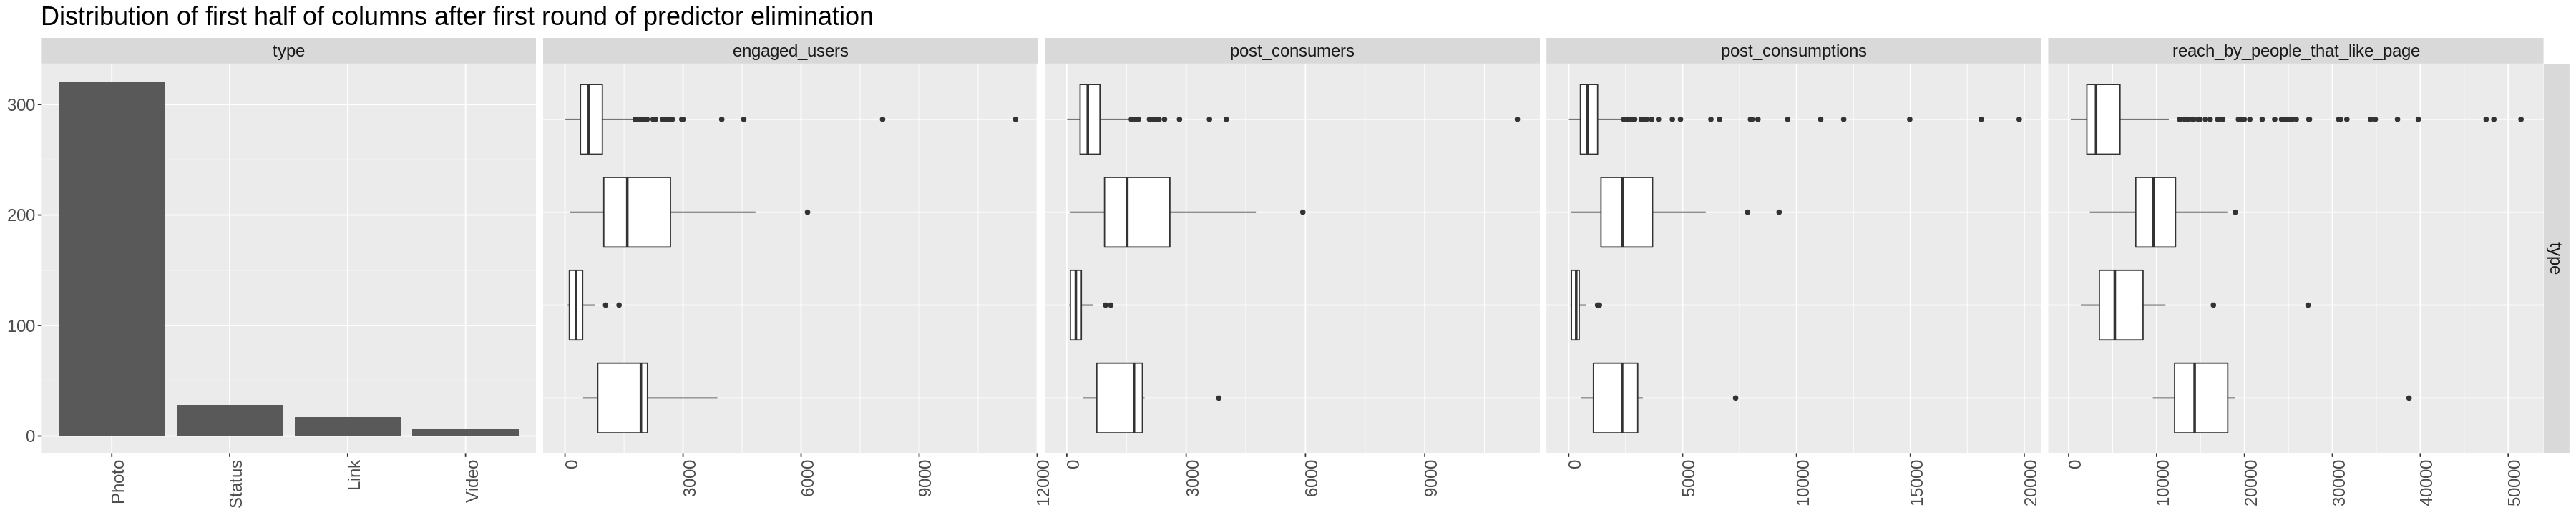

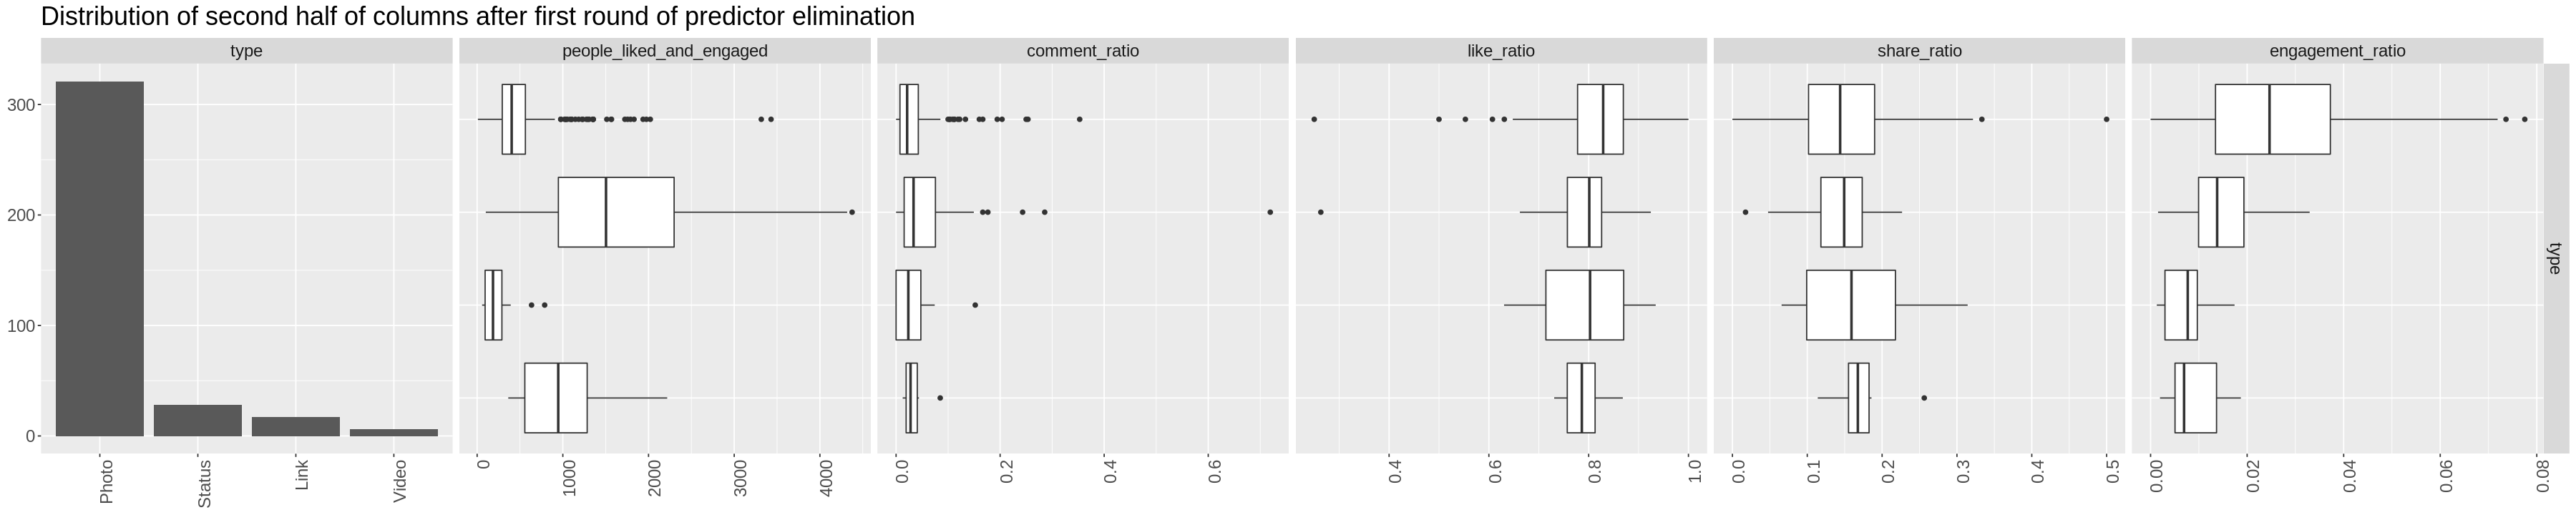

In [251]:
options(repr.plot.height = 6, repr.plot.width = 30)
fb_select_plot2_first <- fb_train_selected2 %>%
    select(type:reach_by_people_that_like_page) %>% 
    ggpairs() +
    ggtitle("Distribution of first half of columns after first round of predictor elimination") +
    theme(text = element_text(size=18),
        axis.text.x = element_text(angle = 90, hjust = 1))

fb_select_plot2_second <- fb_train_selected2 %>% 
    select(type, people_liked_and_engaged:engagement_ratio) %>% 
    ggpairs() +
    ggtitle("Distribution of second half of columns after first round of predictor elimination") +
    theme(text = element_text(size=18),
        axis.text.x = element_text(angle = 90, hjust = 1))

# Select just the top row of each plot, because it is the only thing that we are trying to compare
fb_select_plot2_first$nrow <- 1
fb_select_plot2_first$yAxisLabels <- fb_select_plot2_first$yAxisLabels[1]
fb_select_plot2_first

fb_select_plot2_second$nrow <- 1
fb_select_plot2_second$yAxisLabels <- fb_select_plot2_second$yAxisLabels[1]
fb_select_plot2_second

`comment_percent`, `like_percent`, and `share_percent` look very different now. `comment_percent` still does not look like it would be good, but `like_percent`, and `share_percent` seem like they could be good as the variance for each box plot looks different enough where you can tell them apart.

In [ ]:
fb_data_selected <- fb_data_selected2 %>% 
            select(-comment_percent)
fb_data_selected

fb_test_selected <- fb_test_selected2 %>% 
            select(-comment_percent)

Something else we want to think about is there any hidden predictors that we can get from combining other predictors? 
# Should we include this part?
When doing some research on this dataset, we found that some people created a engagement ratio factor that is `interactions` / `reach`. When we ggpairs this with type, we get this:

In [ ]:
fb_select_plot3 <- fb_data_clean %>%
    mutate(engagement_ratio = interactions / reach) %>% 
    select(type, engagement_ratio) %>% 
    ggpairs() +
    ggtitle("Distribution of different factors for Second Selection Set")
    theme(text = element_text(size=14))

# Select just the top row because it is the only thing that we are trt
fb_select_plot3$nrow <- 1
fb_select_plot3$yAxisLabels <- fb_select_plot$yAxisLabels[1]
fb_select_plot3

This looks promising so we will add this as a factor that we want to look at


### Preliminary Summary Tables:

Tables were constructed to gain an initial summary of the data. Table *summary_table1* groups posts by type and computes the total posts, total interactions (including all likes, comments, shares), maximum interactions, and number of paid posts for each type.

In [ ]:
summary_table1 = fb_train %>% 
    group_by(type) %>%
    summarize(total_of_type = n())

summary_table1

Looking at the number of different posts, it is clear that we need to upsample the data. This does raise some concerns about how well it will be able to predict some types (mainly the type `video`), but we are confident that we can still get good results.

#### Selected Columns:

In [ ]:
selected_cols <- (colnames(fb_data_selected))
selected_cols

colnames(fb_test_selected)

### Preliminary visualizations:

# TODO: should we create visualizations? I think the ggpairs exploration should be enough but who knows. - Kol

#### Methods:

Our analysis will use the following input columns of the original dataset: type `page_likes`, `paid`, `reach`, `engaged_users`, `post_consumers`, `post_consumptions`, `reach_by_people_that_like_page`, and `people_liked_and_engaged`. We will also be using the generated columns `comment_percent`, `like_percent`, `share_percent`, and `engagement_ratio`.


Our aim is to use the K-nearest neighbours algorithm to generate a classification model which will classify a post by type (photo, status, link, or video).

To visualize our results, we plan to use a confusion matrix. This will display how often our classification model labels a post correctly, and how often each label gets confused with another. We will also use bar charts to visualize relevant and intermediate results; e.g., we will create a bar chart with post type on the x-axis and interactions on the y-axis, filling out the bars with proportional values of the type of each interaction. As part of the tuning step of creating the model, we can create a line chart to show us the optimal K value. 

#### Expected outcomes and significance:

This analysis hopes to define a relationship between type of post (i.e., photo, status, link, or video) and ratio of the corresponding post’s interaction type. It is expected that videos and photos, for example, may have higher percentages of interactions that are comments and/or likes when compared to a link or status.

This classification application for labeling a post’s type could be helpful in identifying the types of reactions that a post might receive. It is possible that we find images get the most likes, while statuses get the most comments. Knowing how these metrics indicate the type could lead to better targeted ad campaigns that look for a certain type of user engagement.

Future questions following from this analysis may include:
- Do paid posts generate more traffic than unpaid posts?
- Does the category of a post (i.e., “action”, “product”, or “inspiration” classification) affect the overall and/or ratio of interactions on a post?
- Do posts with more interactions overall correlate with increases in users liking a company’s Facebook page? 

In examining the data for classification, it is also expected that trends may emerge which could in the future be used to predict post engagement. This predictive knowledge could be used by companies looking to grow their social media reach, as they may more accurately tailor their posts to yield higher engagement before publishing.

## Create the model

In [ ]:
upsample_recipe <- recipe(type ~ ., data = fb_data_selected) %>% 
                    step_upsample(type, over_ratio = 1, skip = FALSE ) %>% 
                    prep()



fb_data_upsampled <- upsample_recipe %>% bake(fb_data_selected)
fb_data_upsampled


In [ ]:
# Create the tune spec
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
            set_engine("kknn") %>% 
            set_mode("classification")

In [ ]:
# Create the recipe
fb_recipe <- recipe(type ~  # page_likes +
#                             paid +
#                             reach +
#                             engaged_users +
#                             post_consumers +
#                             post_consumptions +
#                             reach_by_people_that_like_page +
#                             people_liked_and_engaged 
#                             likes +
#                             shares +
#                             interactions
                            like_percent +
                            share_percent +
                            paid +
                            engagement_ratio
                    , data = fb_data_upsampled) %>%
#                 step_mutate(likes = likes / interactions,
#                             share_percent = shares / interactions) %>%  #,
#                             engagement_ratio = interactions / reach) %>%
#                 step_upsample(type, over_ratio = 1, skip = FALSE) %>%
                step_scale(all_predictors()) %>% 
                step_center(all_predictors()) %>% 
                prep()

fb_recipe

## Show that we are using the correct columns

In [ ]:
baked_fb <- bake(fb_recipe, fb_data_upsampled)
baked_fb

## Show that data has been upsampled and balanced

In [ ]:
baked_fb %>% 
    group_by(type) %>% 
    summarize(n = n())

## Tune the model:

# Why does output have neighbors 1..15 where it skips some?

In [ ]:
# Create vfolds with v
fb_vfold <- vfold_cv(baked_fb, v = 10, strata = type)


In [ ]:
gridvals = tibble(neighbors = 1:20)

fb_fit <- workflow() %>% 
        add_recipe(fb_recipe) %>% 
        add_model(knn_spec_tune) %>% 
        tune_grid(resamples = fb_vfold, grid = gridvals) %>% 
        collect_metrics()

fb_fit

In [ ]:
fb_filtered <- fb_fit %>% filter(.metric == "accuracy")

fb_filtered %>% ggplot(aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            scale_x_continuous(breaks = 1:20)

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(fb_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = baked_fb)
knn_fit

In [ ]:
fb_test_predictions <- predict(knn_fit, fb_test_selected) %>%
  bind_cols(fb_test_selected)
fb_test_predictions

fb_test_selected

In [ ]:
fb_test_predictions %>%
  metrics(truth = type, estimate = .pred_class)

### References: 
Statista. (2021). Facebook: Monthly Active Users 2021. Retrieved on February 28, 2021 from http://www.statista.com.ezproxy.library.ubc.ca/statistics/264810/number-of-monthly-active-facebook-users-worldwide/
